### Generative Adversarial Network for MNIST

In [137]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, TensorDataset

#### Read in the data and set up data loader

In [138]:
# Read the data in
data = pd.read_csv('./data/mnist_train.csv')

# Extract the X and y training data and normalise.
X_train = data[data.columns[1:]].as_matrix()/255
y_train = data['5'].as_matrix()

# Convert into PyTorch tensors.
X_train_tensor = torch.Tensor(X_train)
y_train_tensor = torch.Tensor(y_train)

# Define the batch size and number of epochs.
batch_size = 32
epochs = 50

# Create data loader.
train_data = TensorDataset(X_train_tensor, y_train_tensor)
train_data_loader = DataLoader(train_data, batch_size, shuffle=True)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """
/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


#### Define the discriminator and generator networks

In [143]:
class DiscriminatorNetwork(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, output_size),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        output = self.network(x)
        return output

class GeneratorNetwork(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, output_size),
            nn.Sigmoid()
        )
    
    def forward(self, z):
        output = self.network(z)
        return output
        

#### Define the discriminator and generator loss functions

In [144]:
def discriminator_loss_function(discriminator_output, generator_output):
    all_ones = torch.ones_like(discriminator_output)
    all_zeros = torch.zeros_like(generator_output)
    
    discriminator_output_loss = nn.BCELoss()(discriminator_output, all_ones)
    generator_output_loss = nn.BCELoss()(generator_output, all_zeros)

    loss = discriminator_output_loss + generator_output_loss

    return loss

def generator_loss_function(generator_output):
    all_ones = torch.ones_like(generator_output)
    
    loss = nn.BCELoss()(generator_output, all_ones)
    
    return loss
    
def generate_noise_encoding(batch_size, dimension):
    noise = torch.randn((batch_size, dimension))

    return noise

#### Instantiate the model and train the networks

In [145]:
encoding_dimension = 100

discriminator = DiscriminatorNetwork(784, 1)
generator = GeneratorNetwork(encoding_dimension, 784)

discriminator_criterion = discriminator_loss_function
generator_criterion = generator_loss_function

d_optimiser = torch.optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimiser = torch.optim.Adam(generator.parameters(), lr=0.0002)

In [146]:
%matplotlib inline
import matplotlib.pyplot as plt

test_images = []
test_encodings = generate_noise_encoding(5, encoding_dimension)
test_images.append(generator(test_encodings))

d_losses = []
g_losses = []
for epoch in range(epochs):
    generator_losses = []
    discriminator_losses = []
    for features, _ in train_data_loader:
        
        # Discriminator training
        d_optimiser.zero_grad()
        
        encodings = generate_noise_encoding(batch_size, encoding_dimension)
        generated_images = generator(encodings).detach()
        
        real_output = discriminator(features)
        fake_output = discriminator(generated_images)
        
        discriminator_loss = discriminator_criterion(real_output, fake_output)
        discriminator_loss.backward()
        d_optimiser.step()
        
        # Generator training
        g_optimiser.zero_grad()
        
        encodings = generate_noise_encoding(batch_size, encoding_dimension)
        generated_images = generator(encodings)
        
        fake_output = discriminator(generated_images)
        
        generator_loss = generator_criterion(fake_output)
        generator_loss.backward() 
        g_optimiser.step()
        
        discriminator_losses.append(discriminator_loss.detach().numpy())
        generator_losses.append(generator_loss.detach().numpy())
    
    d_losses.append(np.mean(discriminator_losses))
    g_losses.append(np.mean(generator_losses))

    test_images.append(generator(test_encodings))
    
    print("Discriminator Loss: %f\t Generator Loss: %f" % (np.mean(discriminator_losses), np.mean(generator_losses)))

        
        

Discriminator Loss: 0.049819	 Generator Loss: 11.049409
Discriminator Loss: 0.015000	 Generator Loss: 7.767589
Discriminator Loss: 0.025708	 Generator Loss: 6.759533
Discriminator Loss: 0.034420	 Generator Loss: 6.891946
Discriminator Loss: 0.054873	 Generator Loss: 6.523810
Discriminator Loss: 0.090986	 Generator Loss: 5.751652
Discriminator Loss: 0.120208	 Generator Loss: 5.394824
Discriminator Loss: 0.164836	 Generator Loss: 4.784791
Discriminator Loss: 0.240250	 Generator Loss: 4.189554
Discriminator Loss: 0.339962	 Generator Loss: 3.505766
Discriminator Loss: 0.420468	 Generator Loss: 2.930413
Discriminator Loss: 0.481669	 Generator Loss: 2.605356
Discriminator Loss: 0.531214	 Generator Loss: 2.433328
Discriminator Loss: 0.565804	 Generator Loss: 2.281012
Discriminator Loss: 0.579946	 Generator Loss: 2.245413
Discriminator Loss: 0.599662	 Generator Loss: 2.163952
Discriminator Loss: 0.619210	 Generator Loss: 2.084973
Discriminator Loss: 0.623371	 Generator Loss: 2.098969
Discrimin

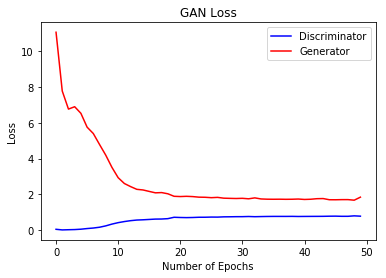

In [149]:
%matplotlib inline
plt.plot(range(len(d_losses)), d_losses, color='b', label="Discriminator")
plt.plot(range(len(g_losses)), g_losses, color='r', label="Generator")
plt.title("GAN Loss")
plt.xlabel('Number of Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### Plot the generated images on five sampled encodings over multiple epochs

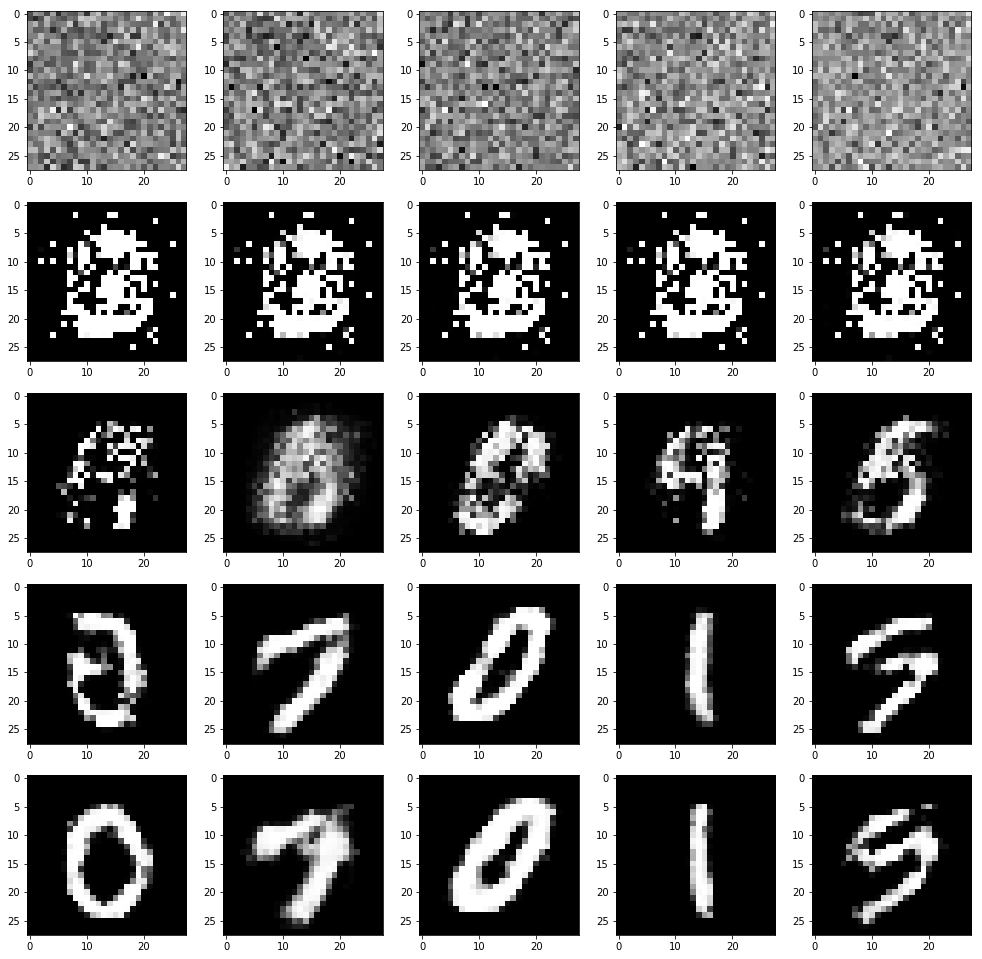

In [150]:
%matplotlib inline

counter = 0
fig, ax = plt.subplots(5, 5, figsize=(17, 17))

for epoch, images in enumerate(test_images):
    if epoch == 0 or epoch == 1 or epoch == 5 or epoch == 30 or epoch == 50:
        for i, image in enumerate(images):
            ax[counter, i].imshow(image.view(28, 28).detach().numpy(), cmap='gray')
        counter += 1

plt.show()